In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
import xarray as xr
import flox.xarray

Matplotlib created a temporary cache directory at /jobfs/117619349.gadi-pbs/matplotlib-2krtvmjr because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
# client.close()

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=12)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44041,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:37815,Total threads: 1
Dashboard: /proxy/38359/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:38583,


# SSP Data

In [4]:
SSP_PATH = '/g/data/w40/ab2313/PhD/time_of_emergence/ssp/pr_Amon_ACCESS-ESM1-5_ssp585_r4i1p1f1_gn_201501-210012.nc'

In [5]:
ssp_raw_ds = xr.open_dataset(SSP_PATH)['pr']
ssp_raw_ds = ssp_raw_ds * 86400

In [6]:
ssp_ds = ssp_raw_ds.resample(time='QS-DEC').sum().compute()
ssp_ds = ssp_ds.where(ssp_ds.time.dt.month == 12, drop=True)

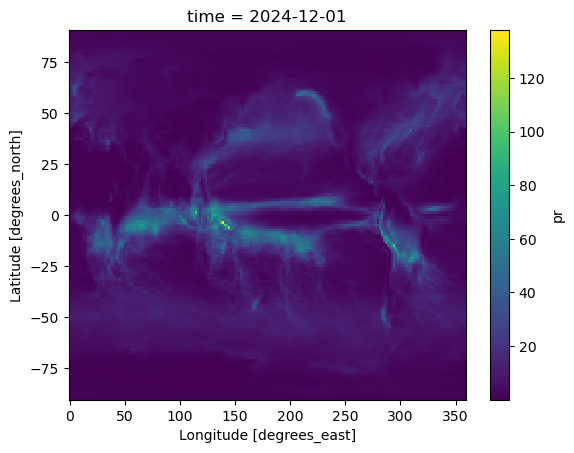

In [7]:
ssp_ds.isel(time=10).plot()

# 20CR

In [8]:
DATA_PATH = '/g/data/ua8/LE_models/20CRv3/mean_monthly/prate.mon.mean.nc'

In [9]:
precip_obs_raw_ds = xr.open_dataset(DATA_PATH).chunk({'time':-1, 'lon':60})
precip_obs_raw_ds = precip_obs_raw_ds * 86400

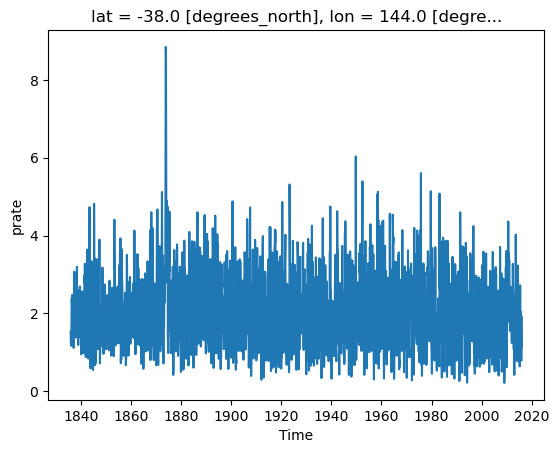

In [39]:
precip_obs_raw_ds.sel(lat=-38, lon=144, method='nearest').prate.plot()

In [10]:
precip_obs_ds = precip_obs_raw_ds.resample(time='QS-DEC').sum().compute()
precip_obs_ds = precip_obs_ds.where(precip_obs_ds.time.dt.month == 12, drop=True)

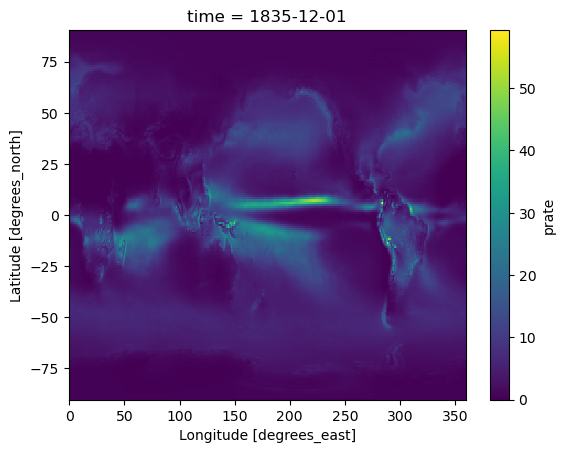

In [11]:
precip_obs_ds.isel(time=0).prate.plot()

# Merge

In [12]:
xr.set_options(display_expand_data=False)
xr.set_options(display_expand_attrs=False)

In [13]:
precip_obs_ds.time.values[-1]

numpy.datetime64('2015-12-01T00:00:00.000000000')

In [14]:
ssp_sub_ds = ssp_ds.sel(time=ssp_ds.time.dt.year>precip_obs_ds.time.dt.year.values[-1])

In [15]:
precip_obs_ds = precip_obs_ds.prate
precip_obs_ds.name = 'pr'

In [16]:
precip_obs_ds

<xarray.DataArray 'pr' (time: 181, lat: 181, lon: 360)> Size: 94MB
0.4052 0.4052 0.4052 0.4052 0.4052 0.4052 ... 0.4836 0.4836 0.4836 0.4836 0.4836
Coordinates:
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1kB 1835-12-01 1836-12-01 ... 2015-12-01

In [21]:
ssp_sub_ds

<xarray.DataArray 'pr' (time: 85, lat: 145, lon: 192)> Size: 19MB
0.6158 0.6158 0.6158 0.6158 0.6158 0.6158 ... 0.4686 0.4686 0.4686 0.4686 0.4686
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 680B 2016-12-01 2017-12-01 ... 2100-12-01

In [20]:
import climtas

In [23]:
regridder = climtas.regrid.Regridder(precip_obs_ds , ssp_sub_ds)

regridded_file = regridder.regrid(precip_obs_ds)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/climtas/regrid.py:380: UserWarning: rename 'i' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  target_da = target_da.rename({"i": "lat", "j": "lon"})
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/climtas/regrid.py:380: UserWarning: rename 'j' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  target_da = target_da.rename({"i": "lat", "j": "lon"})


In [27]:
regridded_file = regridded_file.compute()

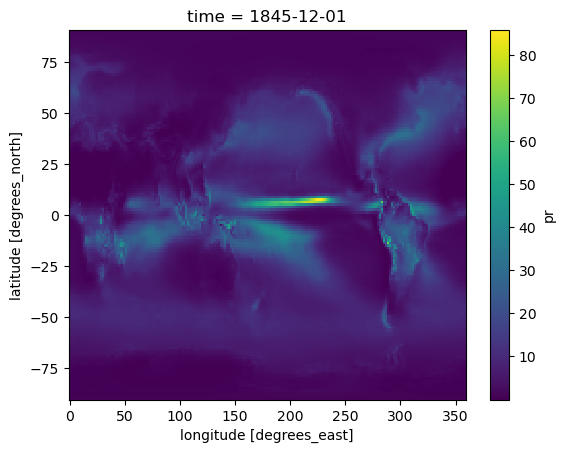

In [28]:
regridded_file.isel(time=10).plot()

In [29]:
precip_ds = xr.concat([regridded_file, ssp_sub_ds], dim='time')

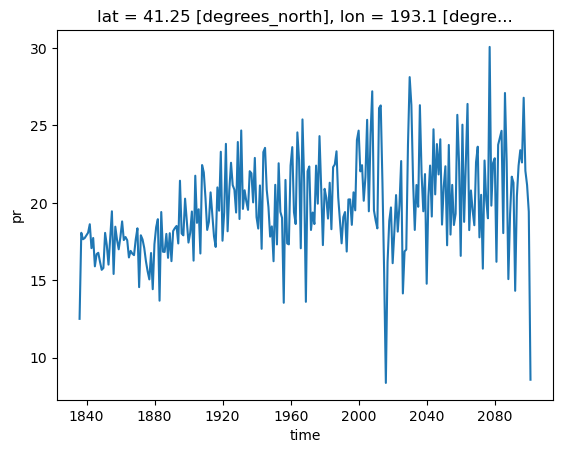

In [36]:
precip_ds.sel(lat=41, lon=194, method='nearest').plot()

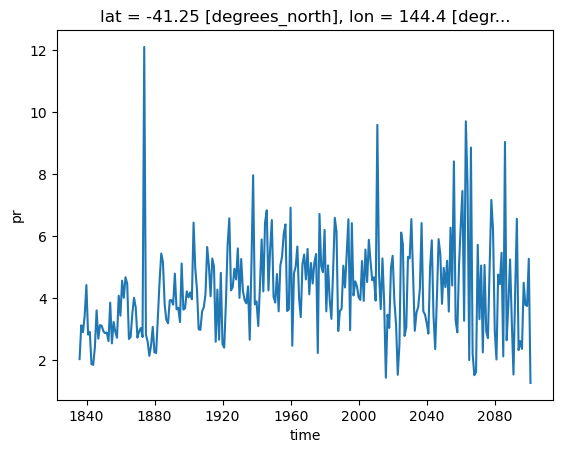

In [33]:
precip_ds.sel(lat=-41, lon=144, method='nearest').plot()

In [41]:
precip_ds.to_netcdf('/g/data/w40/ab2313/PhD/time_of_emergence/20CR_ACCESS_SSP585.nc')

# Old

In [110]:
# DATA_PATH = '/g/data/ua8/LE_models/20CRv3/mean_daily/prate'

# os.listdir(DATA_PATH)[:5]
# def __preprocess_20CR(ds):
#     return ds['prate']
# paths = os.listdir(DATA_PATH)[:15]

# paths = os.path.join(DATA_PATH, '*.nc')
# precip_raw_ds = xr.open_mfdataset(paths, preprocess=__preprocess_20CR).chunk({'time':-1, 'lon':90, 'lat':18})

# precip_raw_ds = precip_raw_ds.where(precip_raw_ds.time.dt.month.isin([12, 1,2]), drop=True)

# precip_raw_ds

# %%time
# precip_ds = precip_raw_ds.resample(time='QS-DEC').sum()#.compute()
# precip_ds = precip_ds.compute()

# # %%time
# # # precip_ds2 =flox.xarray.xarray_reduce(precip_ds, dim='time', freq='QS-DEC', func='sum')

# precip_ds = precip_ds *  8640/3

# precip_ds = precip_ds.sel(time=precip_ds.time.dt.month==12)

# precip_ds.isel(time=10).prate.plot()

In [ ]:
#https://flox.readthedocs.io/en/latest/user-stories/climatology-hourly.html
# flox.xarray.xarray_reduce(ds.tp, ds.time.dt.hour, func="mean")
rx1d_ds_flox = flox.xarray.xarray_reduce(precip_ds.prate, precip_ds.time.dt.year, func='max')
rx1d_ds_flox = rx1d_ds_flox.compute()

Task exception was never retrieved
future: <Task finished name='Task-256913' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-256917' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved

In [68]:
rx1d_ds = precip_ds.resample(time='YE').max().compute()

Task exception was never retrieved
future: <Task finished name='Task-109342' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 12.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
# SSP_OPENDAP_URL = 'https://esgf.nci.org.au/thredds/dodsC/master/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r5i1p1f1/Amon/pr/gn/v20210318/pr_Amon_ACCESS-ESM1-5_ssp585_r5i1p1f1_gn_210101-230012.nc'

In [70]:
rx1d_ds.prate.

<xarray.Dataset> Size: 47MB
Dimensions:  (time: 180, lat: 181, lon: 360)
Coordinates:
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1kB 1836-12-31 1837-12-31 ... 2015-12-31
Data variables:
    prate    (time, lat, lon) float32 47MB 5.125e-06 5.125e-06 ... 9.45e-05